In [235]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
from torch.utils.data import DataLoader
from tqdm import tqdm
from crp.image import imgify, vis_opaque_img, plot_grid
from torch.optim import SGD, Adam

import copy

In [236]:
from expbasics.leemann import disjoint_orthogonality_loss, nearest_neighbors, vis_nearest_neighbors
from expbasics.helper import get_attribution_function, get_model_etc
from expbasics.network import train_network, accuracy_per_class
from expbasics.biased_noisy_dataset import BiasedNoisyDataset, get_biased_loader
from expbasics.ground_truth_measures import GroundTruthMeasures
from expbasics.crp_attribution import CRPAttribution
from torch.utils.data import Dataset, DataLoader, random_split

%reload_ext autoreload
%autoreload 2

In [237]:
BIAS = 0.94
BATCH_SIZE = 128
N_BASIS = 2
BATCH_STEP_SIZE = 256
NUM_NEIGHBORS = 36
SPATIAL_STEPSIZE = 1

MAX_INDEX = 491520
STRENGTH = 0.5
LR = 0.001

LAYER_NAME = "linear_layers.0"

model, gm, crp_attribution, unbiased_ds, test_loader = get_model_etc(BIAS)

#dataset = BiasedNoisyDataset(BIAS, STRENGTH, True)
#res = accuracy_per_class(model, test_loader)

In [194]:
loader = get_biased_loader(0.0, 0.5, split=0.05, verbose=False)
train_loader = get_biased_loader(BIAS, 0.5,split=0.05, batch_size=BATCH_SIZE, verbose=False)

accs = accuracy_per_class(model, loader)
accs_normal =accuracy_per_class(model, train_loader, disable=False)
accs, accs_normal

100%|██████████| 192/192 [00:12<00:00, 15.07it/s]


([52.38669238187078, 57.37718430596769, 54.85026168823242],
 [0.0, 100.0, 49.91048049926758])

1 [{'train_accuracy': [100.0, 0.0, 49.84130859375], 'all_wm_accuracy': [100.0, 0.0, 50.20751953125], 'no_wm_accuracy': [100.0, 0.0, 49.873863220214844], 'bias': 0.96, 'strength': 0.5, 'learning_rate': 0.001, 'num_it': 0}]


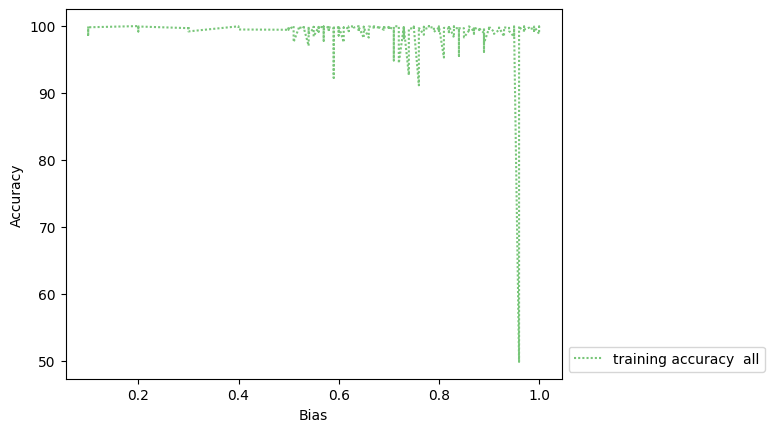

In [207]:
from expbasics.visualizations import plot_accuracies

plot_accuracies("outputs/noise_pos_accuracies.json")

0
output: tensor([[ 9.5017, -4.4666]]), 
 latents: [ 0  0 30  6 14], 
 watermark: False, 
 prediction:0  
 
 convolutional_layers.0: 
 4: 21.13%, 1: 19.71%, 0: 19.45%, 2: 18.29%, 6: 10.47%, 7: 5.58%, 3: 5.38%, 5: 0.0% 
 
 convolutional_layers.3: 
 1: 39.28%, 5: 23.58%, 6: 15.11%, 4: 7.85%, 7: 6.96%, 2: 0.0%, 0: 0.0%, 3: -7.22% 
 
 convolutional_layers.6: 
 1: 33.99%, 3: 23.21%, 2: 11.56%, 7: 0.0%, 0: 0.0%, 4: -2.37%, 6: -7.67%, 5: -21.2% 
 
 linear_layers.0: 
 1: 31.32%, 3: 22.19%, 0: 15.78%, 2: 14.29%, 4: 0.0%, 5: -16.42% 
 
 linear_layers.2: 
 0: 100.0%, 1: 0.0% 


' with open("outputs/noise_pos_accuracies.json", "r") as f:\n    accuracies = json.load(f)\n    for k, item in accuracies.items(): '

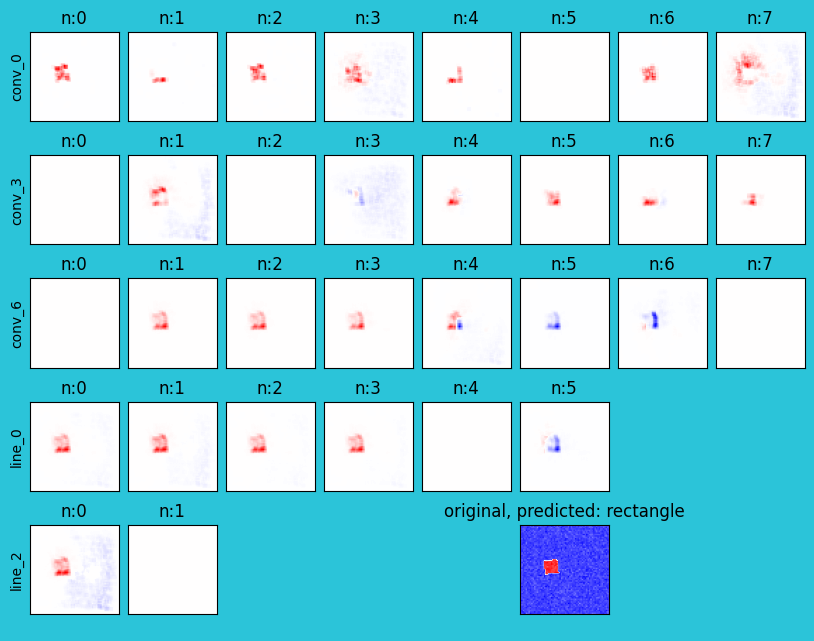

In [265]:
import json
FV_NAME = "noise_pos"
index = np.random.randint(0, MAX_INDEX)
img, target = unbiased_ds[index]
print(target)
crp_attribution.image_info(index, verbose=True)
""" with open("outputs/noise_pos_accuracies.json", "r") as f:
    accuracies = json.load(f)
    for k, item in accuracies.items(): """

/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


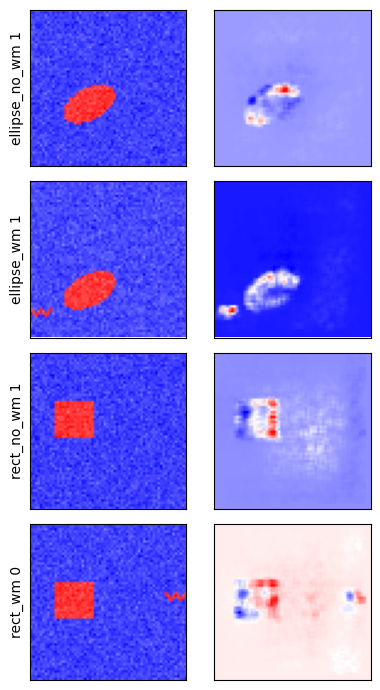

In [817]:
pnam = ["rectangle", "ellipse"]

imgdict = {
    f"ellipse_no_wm {preds[0]}": img[0:2],
    f"ellipse_wm {preds[1]}": img[2:4],
    f"rect_no_wm {preds[2]}": img[4:6],
    f"rect_wm {preds[3]}": img[6:],
}

plot_grid(imgdict, figsize=(4,7), symmetric=True)

In [821]:
model.eval()
wrong = []
wrong_idx = []
STEP_SIZE = 900
idx = np.array(list(range(0, MAX_INDEX, STEP_SIZE)))
with torch.no_grad():
    for count, index in enumerate(idx):
        x, target = unbiased_ds[index]
        output = model(x.view(1, 1, 64, 64))
        preds = output.data.max(dim=1)[1]
        if target != preds:
            if preds == 1:
                wrong += [np.linalg.norm(output.data[0] - torch.Tensor([1,0]))]
            else:
                wrong += [np.linalg.norm(output.data[0] - torch.Tensor([0,1]))]
            wrong_idx.append(index)
wrong = np.array(wrong)
wrong_idx = np.array(wrong_idx)
inds = np.argsort(1/wrong)
wrong = wrong[inds]
wrong_idx = wrong_idx[inds]
len(wrong)

34

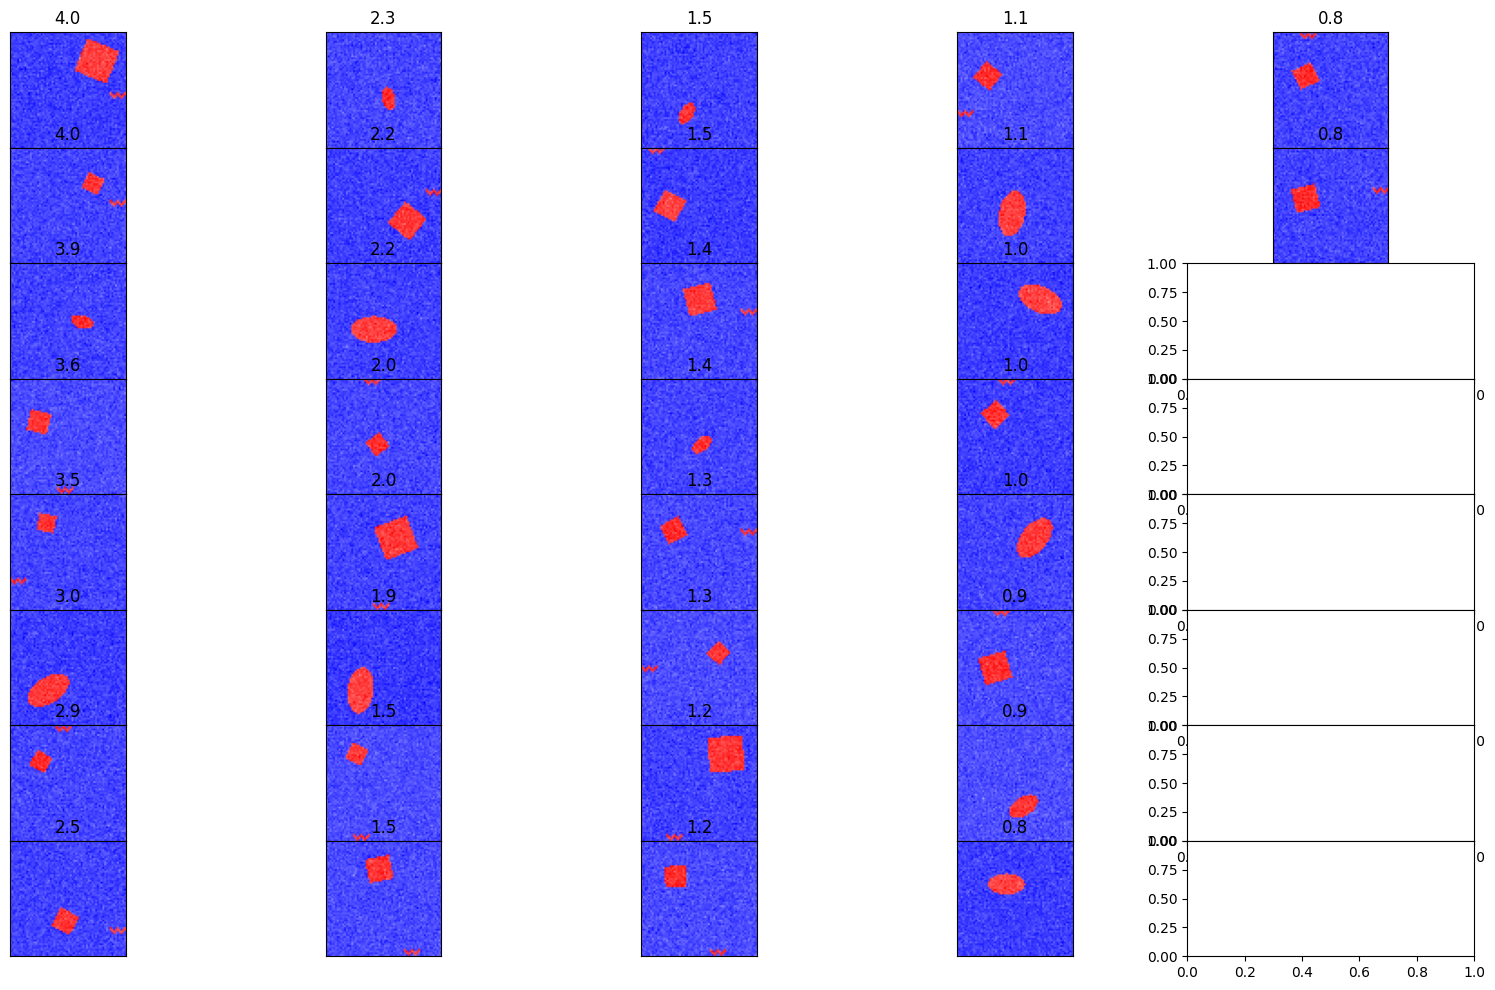

In [823]:
amt = max(len(wrong_idx), 32)

modulo = 8
f, ax = plt.subplots(
    modulo, (amt// modulo) +1 , figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0}
)
for n in range(amt):
    ax[n%modulo, n // modulo].xaxis.set_visible(False)
    ax[n%modulo, n // modulo].yaxis.set_visible(False)
    if n < amt:
        ax[n%modulo, n // modulo].set_title(round(wrong[n],1))
        ax[n%modulo, n // modulo].imshow(imgify(unbiased_ds[wrong_idx[n]][0][0]))

In [179]:
MAX_INDEX = 491520
STEP_SIZE = 1000
single_attr = get_attribution_function(model, heatmap=False, batch_size=1)
# cavs_loader = DataLoader(unbiased_ds, batch_size=BATCH_SIZE, shuffle=False)

idx = np.array(list(range(0, MAX_INDEX, STEP_SIZE)))
cavs = torch.zeros((len(idx), 6))
for count, index in enumerate(idx):
    x, _ = unbiased_ds[index]
    res = single_attr(x).detach().contiguous()
    cavs[count] = res

tensor([0., 0., 0., 0., 0., 0.])


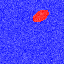

In [180]:
randi = np.random.randint(0, len(idx))
print(cavs[randi])
imgify(unbiased_ds[idx[randi]][0])

In [181]:
loss_fn = lambda x: disjoint_orthogonality_loss(
    x, normalize=True, disjoint=True, losstype="offdiagl2"
)
attribution_fn = get_attribution_function(model, heatmap=False)


def train_loop(
    model, attribution_fn, loss_fn, n_iter=100, ground_truth_dirs=None, optimize=True
):
    """Main look to recover the matrix M such that the directions fulfill the IMA/DMA criterion.
    Parameters:
        args: Command line arguments
        model: The trained encoder.
        A_init: Intial matrix M at the start of the optimization
        attribution_fn: Function to compute the gradients. Can be used to implement variations
            of the gradient such as integrated or smoothed grad.
        loss_fn: Function that computes the loss
        logger: Custom logger object to log the optimization progress
        n_iter: Number of iterations to perform
        ground_truth_dirs: Ground truth directions if known (required to compute some alignment metrics)
        optimize: True, if A should be optimized, otherwise only the loss and the metrics are computed and logged.
    Returns the matrix with the discovered directions and the average loss
    """
    A_init = torch.randn(2, 6) #eye
    if optimize:
        A = A_init.clone()
        A.requires_grad_(True)

        opt = Adam((A,), lr=LR)
    else:
        A = A_init

    running_loss = 0.0
    cum_loss = 0.0
    with tqdm(total=n_iter, position=0, leave=True) as pbar:
        epoch_sz = len(test_loader)
        for epoch in range(n_iter // epoch_sz + 1):
            for i, data in enumerate(test_loader):
                x, _ = data
                J = attribution_fn(x).detach().contiguous()
                #J = J[:,[1,3,4]]
                J = J.view(J.size(0), J.size(1), -1)  # [B, latent_dim, input_dim]
                disentangledJ = torch.matmul(A.unsqueeze(0), J) #A.unsqueeze(0)
                disentangledJ = disentangledJ.reshape(J.size(0), A.size(0))
                loss = torch.mean(loss_fn(disentangledJ)[1])
                if optimize:
                    loss.backward()
                    opt.step()
                running_loss += loss.detach().item()
                cum_loss += loss.detach().item()
                pbar.update(1)
                if epoch * epoch_sz + i >= n_iter:
                    print("over")
                    break
    return A.detach(), cum_loss / n_iter

H, loss = train_loop(model, attribution_fn, loss_fn)
H, loss

  0%|          | 0/100 [00:00<?, ?it/s]

101it [01:03,  1.60it/s]                         

over


(tensor([[nan, nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan]]),
 nan)

In [117]:
nn_idx = nearest_neighbors(H, cavs, idx, NUM_NEIGHBORS, "cosine")  # , "cosine"
for i in range(N_BASIS):
    vis_nearest_neighbors(unbiased_ds, nn_idx[i], f"{LAYER_NAME}_cosine_{i}")

/home/lilli/Desktop/MASTER/code/experiments/expbasics/leemann.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H = torch.tensor(H, dtype=torch.float32)


In [118]:
from torch.autograd import grad

crpattr = get_attribution_function(model)

def input_jacobian(net, x):
    """Compute jacobians w.r.t. input. This function is similar to torch.autograd.functional.jacobian
    in later pytorch versions.
    Parameters:
        net: Encoder for which encode_deterministic will be called.
    Return the gradient with respect to each input for each sample.
    """
    x.requires_grad_(True)
    out = net(x)
    J_list = []
    for k in range(net.z_dim):
        J = grad(out[:, k], x, torch.ones_like(out[:, k]), retain_graph=True)[0]
        # print(J.shape)
        J_list.append(J)
    jac = torch.stack(J_list, dim=1)
    return jac


def smoothgrad_gradients(net, x, n_samples=20, noise_lvl=0.02):
    """Return the smoothgrad attributions."""
    noise = noise_lvl * torch.randn(n_samples, *x.shape)
    interps = x.reshape(-1, x.size(0), x.size(1), x.size(2), x.size(3)) + noise
    interps = interps.contiguous()
    old_shape = interps.shape
    # print(interps.shape)
    # flatten inputs to compute model gradients.
    interps = interps.reshape(-1, interps.size(2), interps.size(3), interps.size(4))

    jacs = input_jacobian(net, interps)
    # print(jacs.shape)
    sg = jacs.reshape(
        old_shape[0], old_shape[1], -1, old_shape[2], old_shape[3], old_shape[4]
    ).sum(dim=0)
    return sg

attribution_fn = lambda net, x: smoothgrad_gradients(
    net, x, n_samples=128
)  # get_attribution_function(model)

In [119]:
cond_layer = "linear_layers.0" #"convolutional_layers.6"  # 

t = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
told = torch.zeros((N_BASIS, NUM_NEIGHBORS, 64, 64))
for i in range(N_BASIS):
    for index in range(NUM_NEIGHBORS):
        hold = crp_attribution.heatmap(nn_idx[i][index])
        h = crp_attribution.cav_heatmap(nn_idx[i][index], cond_layer, H[i])
        t[i][index] = h
        told[i][index] = hold


def show_neighbors(hms, index):
    return imgify(
        hms[index],
        grid=(
            math.floor(math.sqrt(NUM_NEIGHBORS)),
            math.floor(math.sqrt(NUM_NEIGHBORS)),
        ),
        symmetric =True
    )


def show_all_cavs(hms):
    f, ax = plt.subplots(
        1, N_BASIS, figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0}
    )
    for n in range(N_BASIS):
        ax[n].xaxis.set_visible(False)
        ax[n].yaxis.set_visible(False)
        ax[n].imshow(show_neighbors(hms, n))

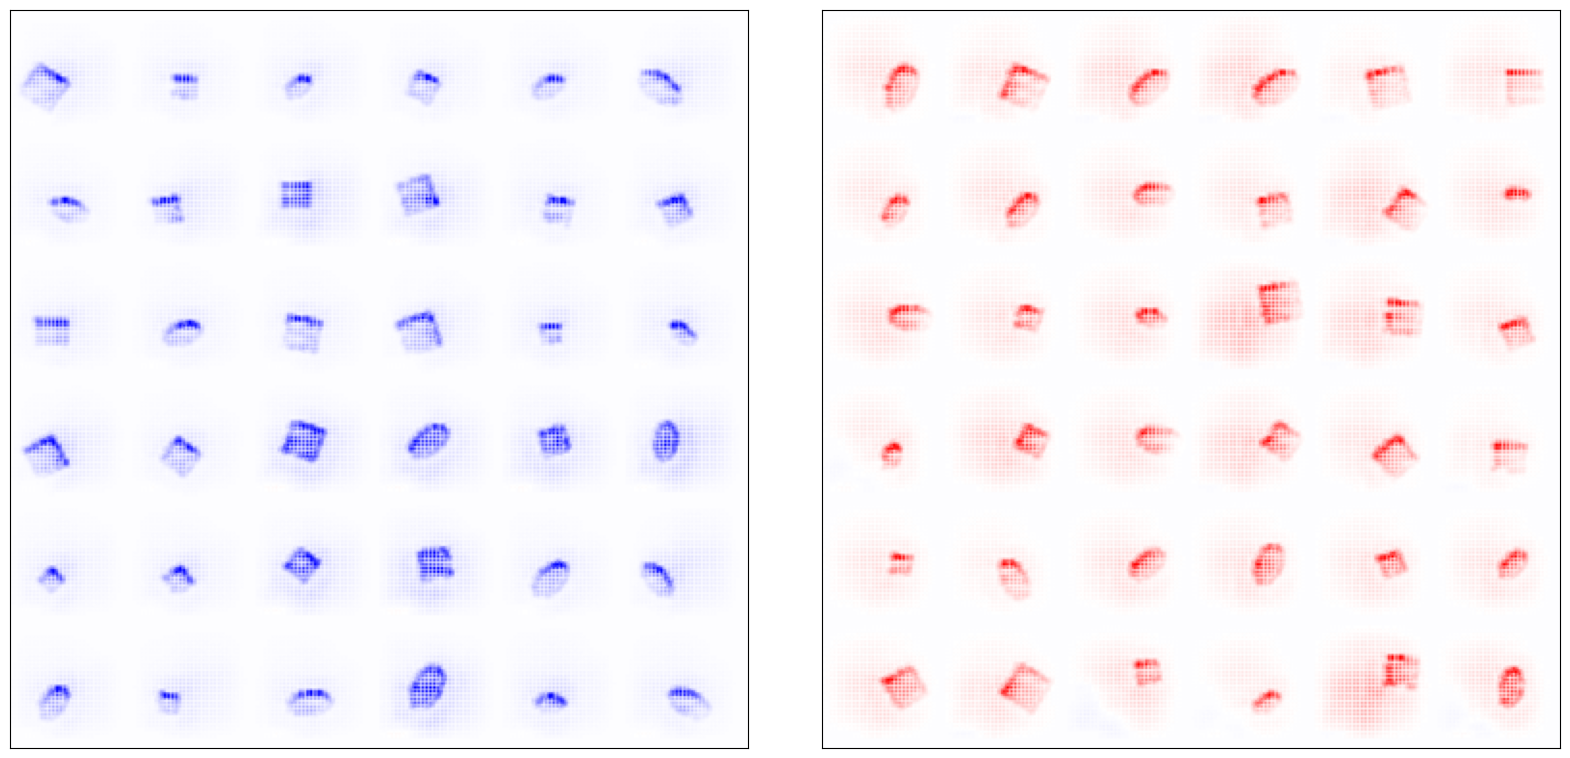

In [120]:
show_all_cavs(t)

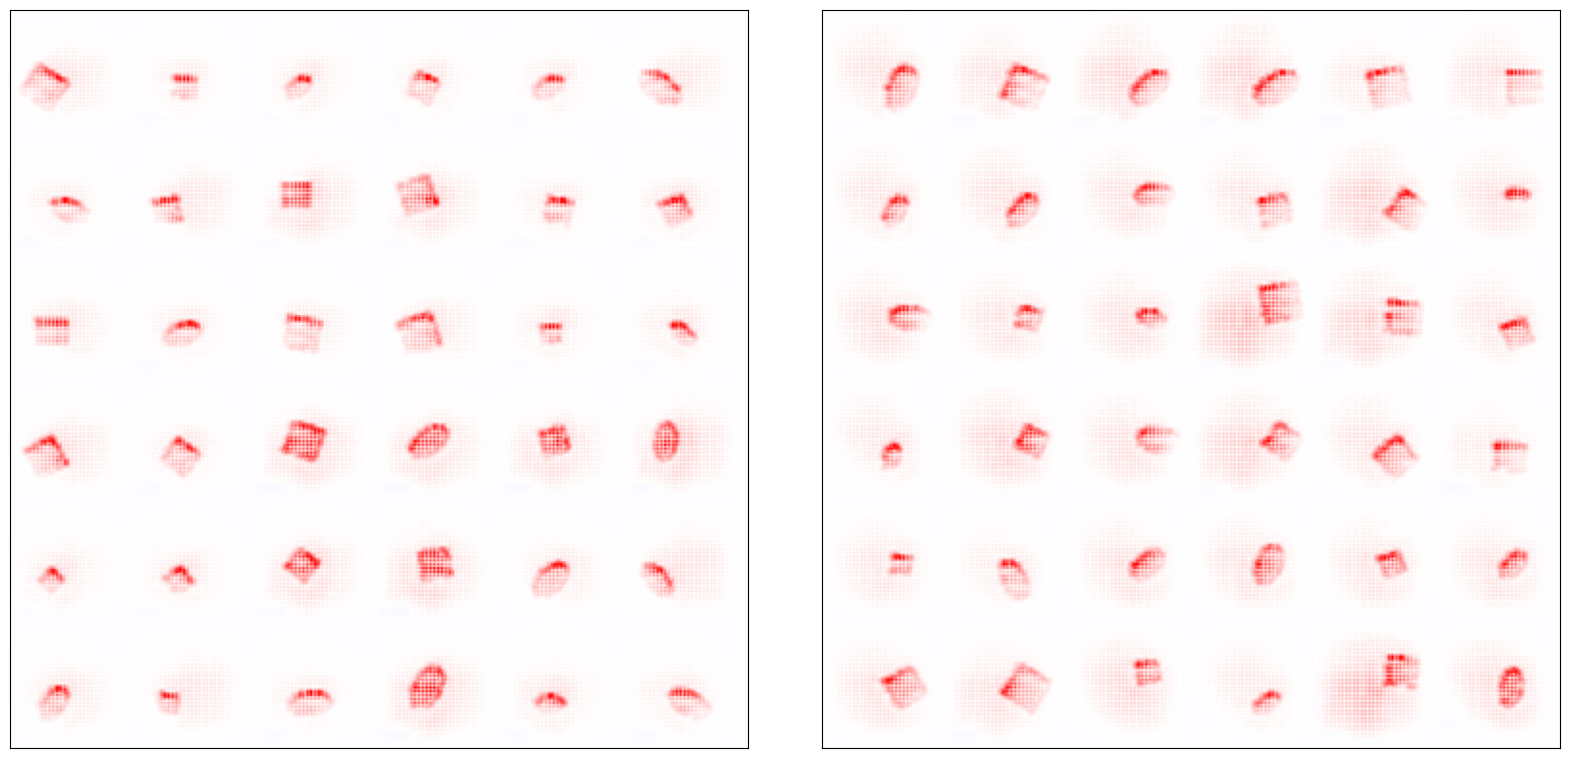

In [121]:
show_all_cavs(told)

In [48]:
H,  [np.intersect1d(nn_idx[x], nn_idx[y]).shape if x != y else "same" for x in range(4) for y in range(4)]


(array([[ 0.        ,  0.        , 11.75612329,  8.71191297, 22.50457525,
          0.        ],
        [ 0.        ,  0.        ,  0.02257934,  0.        ,  0.02345084,
         12.35677329],
        [ 0.        ,  0.        ,  3.80525514,  2.85483271,  4.24792524,
          0.        ],
        [ 0.        ,  0.        ,  4.30456958,  2.68263138,  5.69847257,
          0.        ]]),
 ['same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same',
  (0,),
  (0,),
  (0,),
  (0,),
  'same'])

In [1]:
L1  https://transformer-circuits.pub/2023/monosemantic-features

TCAV -> 

multipliziere activations in latent space mit basisvektoren 
https://arxiv.org/abs/2303.12641

SyntaxError: invalid syntax (911830306.py, line 1)